<a href="https://colab.research.google.com/github/SOWMIYA-BALACHANDAR/PRASUNET-MACHINE-LEARNING/blob/main/ML_TASK_5_CALORIE_TRACKER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A MODEL THAT CAN ACCURATELY RECOGNIZE FOOD ITEMS FROM IMAGES AND ESTIMATE THEIR CALORIE CONTENT, ENABLING USERS TO TRACK THEIR DIETARY INTAKE AND MAKE INFORMED FOOD CHOICES**

**Import libraries**

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from random import sample
import itertools

**Load the Calorie Data**

In [ ]:
calorie_df = pd.read_csv("/content/drive/MyDrive/food/food_calories_tracking.csv")

**Data Generators**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/food/Train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/food/Test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 324 images belonging to 9 classes.
Found 108 images belonging to 9 classes.


**Images from training and test datasets**

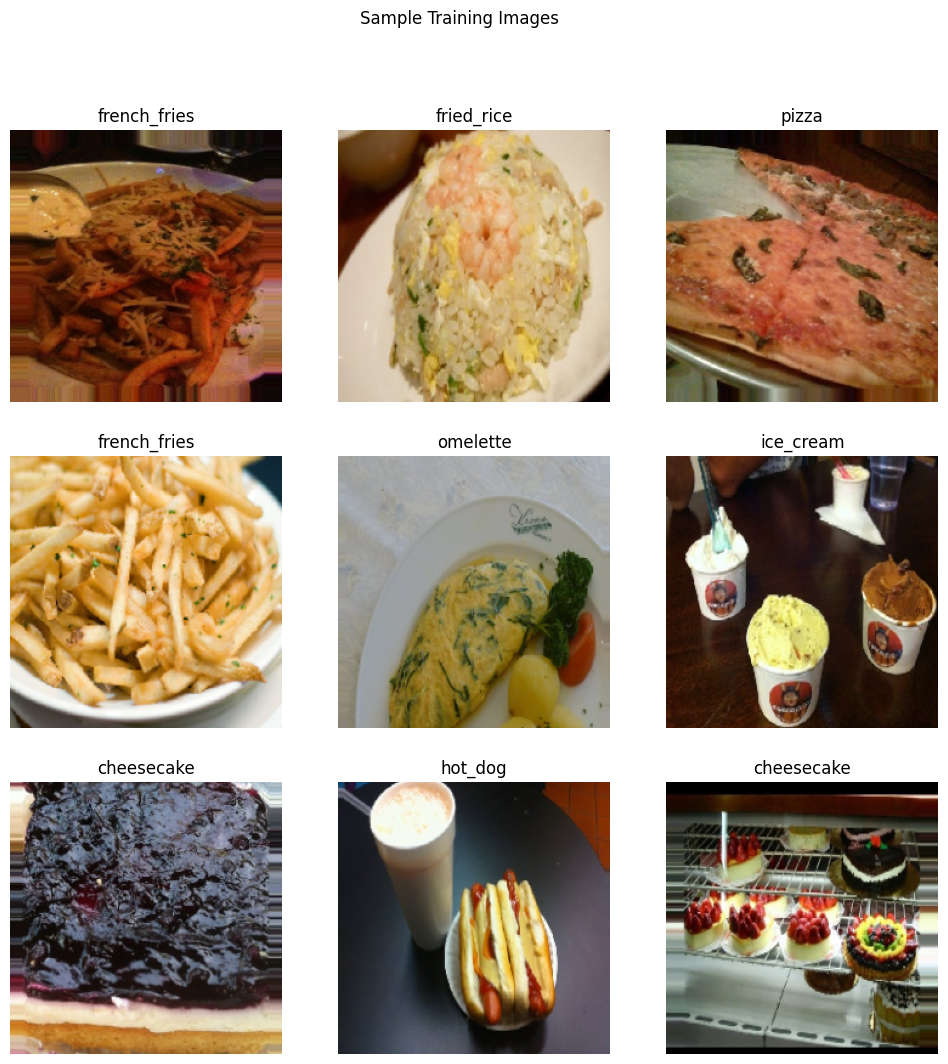

In [49]:
def display_images(generator, title, show_titles=True):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        if show_titles:
            plt.title(class_names[np.argmax(labels[i])])
        else:
            plt.title("Test Image")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(train_generator, "Sample Training Images")

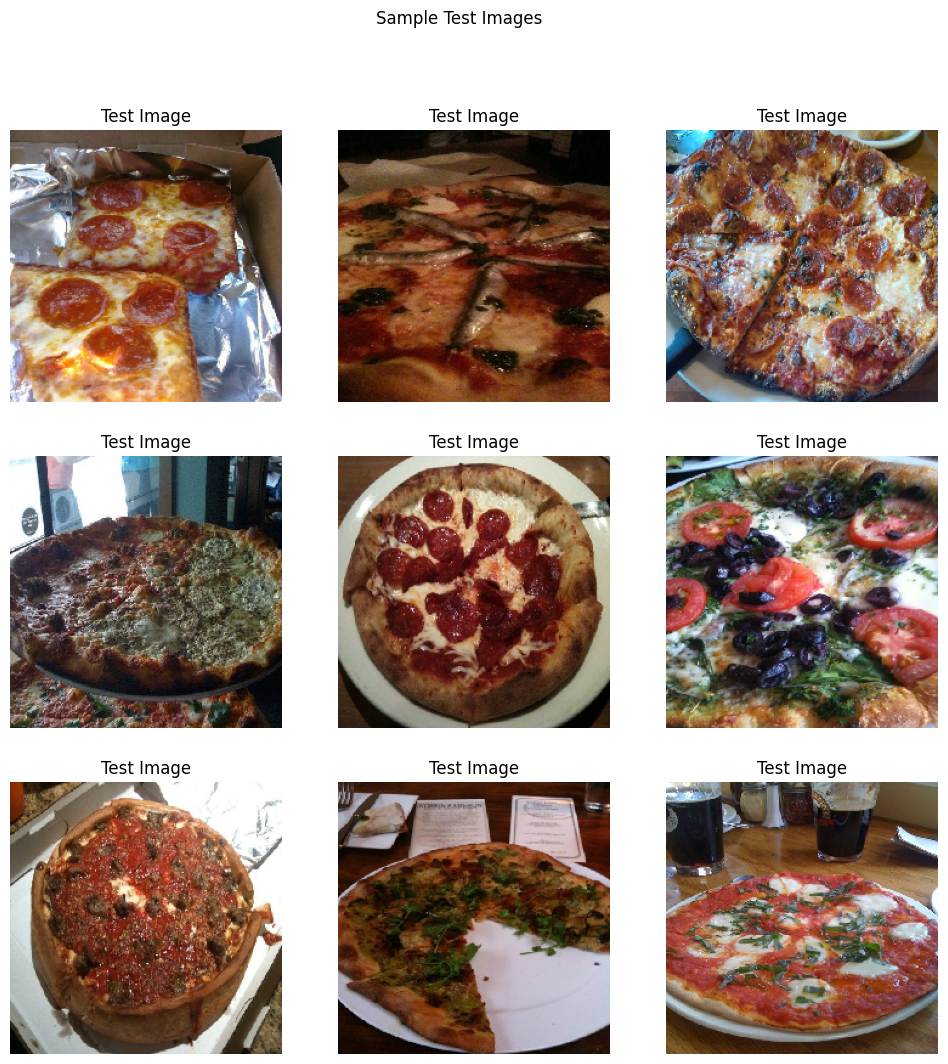

In [50]:
display_images(test_generator, "Sample Test Images", show_titles=False)

**Build and Train the Model**

In [32]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10
)

for layer in base_model.layers[:143]:
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10
)

Epoch 1/10
10/10 [==============================] - 85s 8s/step - loss: 2.6858 - accuracy: 0.0925 - val_loss: 2.2610 - val_accuracy: 0.1250
Epoch 2/10
10/10 [==============================] - 76s 8s/step - loss: 2.5139 - accuracy: 0.1233 - val_loss: 2.1991 - val_accuracy: 0.1250
Epoch 3/10
10/10 [==============================] - 73s 7s/step - loss: 2.3477 - accuracy: 0.1199 - val_loss: 2.4421 - val_accuracy: 0.0312
Epoch 4/10
10/10 [==============================] - 76s 8s/step - loss: 2.2923 - accuracy: 0.1336 - val_loss: 2.2973 - val_accuracy: 0.1354
Epoch 5/10
10/10 [==============================] - 75s 8s/step - loss: 2.3836 - accuracy: 0.1199 - val_loss: 2.4081 - val_accuracy: 0.1250
Epoch 6/10
10/10 [==============================] - 75s 8s/step - loss: 2.3368 - accuracy: 0.1473 - val_loss: 2.2452 - val_accuracy: 0.1354
Epoch 7/10
10/10 [==============================] - 76s 8s/step - loss: 2.2452 - accuracy: 0.1610 - val_loss: 2.2678 - val_accuracy: 0.1250
Epoch 8/10
10/10 [==

**Evaluate the Model**

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3/3 [==============================] - 17s 6s/step - loss: 2.2638 - accuracy: 0.1458
Test Accuracy: 14.58%


**Predict Food and Estimate Calories from Test Dataset**

In [ ]:
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_food(img_path):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)
    food_item = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(pred_class[0])]

    if food_item in calorie_df['Food'].values:
        calories = calorie_df[calorie_df['Food'] == food_item]['Calories per Serving'].values[0]
        return food_item, calories
    else:
        return None, None


**Class indices**

In [ ]:
print("Class Indices: ", train_generator.class_indices)

Class Indices:  {'apple_pie': 0, 'cheesecake': 1, 'chicken_curry': 2, 'french_fries': 3, 'fried_rice': 4, 'hot_dog': 5, 'ice_cream': 6, 'omelette': 7, 'pizza': 8}


**Predicting on all images in the test set**

In [ ]:
test_img_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk("/content/drive/MyDrive/food/Test") for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png']]


**Test image paths**

In [ ]:
print("Test Image Paths: ", test_img_paths)

Test Image Paths:  ['/content/drive/MyDrive/food/Test/pizza/11297.jpg', '/content/drive/MyDrive/food/Test/pizza/12301.jpg', '/content/drive/MyDrive/food/Test/pizza/12718.jpg', '/content/drive/MyDrive/food/Test/pizza/13983.jpg', '/content/drive/MyDrive/food/Test/pizza/27963.jpg', '/content/drive/MyDrive/food/Test/pizza/22489.jpg', '/content/drive/MyDrive/food/Test/pizza/2965.jpg', '/content/drive/MyDrive/food/Test/pizza/29417.jpg', '/content/drive/MyDrive/food/Test/pizza/23199.jpg', '/content/drive/MyDrive/food/Test/pizza/32004.jpg', '/content/drive/MyDrive/food/Test/pizza/5764.jpg', '/content/drive/MyDrive/food/Test/pizza/8917.jpg', '/content/drive/MyDrive/food/Test/cheesecake/1926.jpg', '/content/drive/MyDrive/food/Test/cheesecake/2656.jpg', '/content/drive/MyDrive/food/Test/cheesecake/23673.jpg', '/content/drive/MyDrive/food/Test/cheesecake/34970.jpg', '/content/drive/MyDrive/food/Test/cheesecake/35298.jpg', '/content/drive/MyDrive/food/Test/cheesecake/53831.jpg', '/content/drive/MyD

In [37]:
predictions = []
true_labels = []
predicted_labels = []

for img_path in test_img_paths:
    food_item, calories = predict_food(img_path)
    if food_item and calories:
        predictions.append((img_path, food_item, calories))
        true_label = os.path.basename(os.path.dirname(img_path))
        true_labels.append(true_label)
        predicted_labels.append(food_item)
    else:
        print(f"No calorie information for predicted food item: {food_item}")

1/1 [==============================] - 0s 175ms/step


In [ ]:
print(predictions_df)

                                            Image Path      Food Item  \
0     /content/drive/MyDrive/food/Test/pizza/11297.jpg  chicken_curry   
1     /content/drive/MyDrive/food/Test/pizza/12301.jpg  chicken_curry   
2     /content/drive/MyDrive/food/Test/pizza/12718.jpg        hot_dog   
3     /content/drive/MyDrive/food/Test/pizza/13983.jpg      ice_cream   
4     /content/drive/MyDrive/food/Test/pizza/27963.jpg  chicken_curry   
..                                                 ...            ...   
103  /content/drive/MyDrive/food/Test/chicken_curry...  chicken_curry   
104  /content/drive/MyDrive/food/Test/chicken_curry...  chicken_curry   
105  /content/drive/MyDrive/food/Test/chicken_curry...  chicken_curry   
106  /content/drive/MyDrive/food/Test/chicken_curry...  chicken_curry   
107  /content/drive/MyDrive/food/Test/chicken_curry...      ice_cream   

     Estimated Calories  
0                   250  
1                   250  
2                   151  
3                  

**Visualize Training Progress and Predictions**

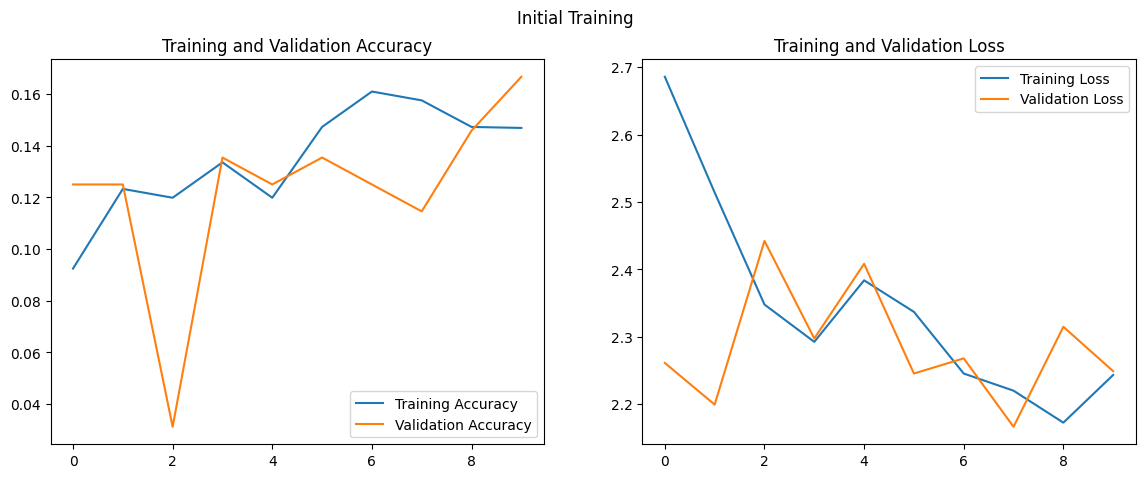

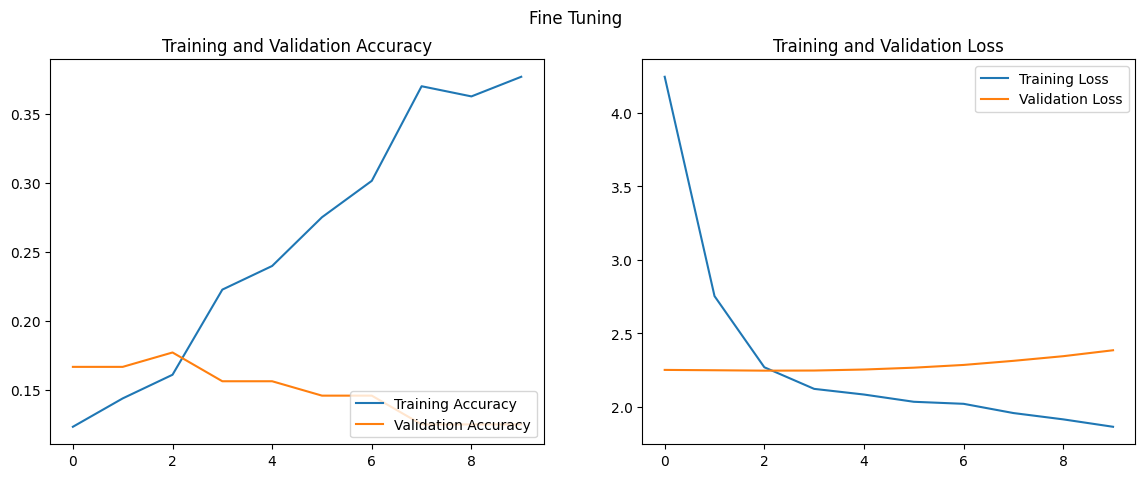

In [34]:
import matplotlib.pyplot as plt
def plot_training(history, fine_tuning=False):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    if fine_tuning:
        plt.suptitle('Fine Tuning')
    else:
        plt.suptitle('Initial Training')

    plt.show()

plot_training(history)
plot_training(history_fine, fine_tuning=True)

**The calorie distribution of the predictions**

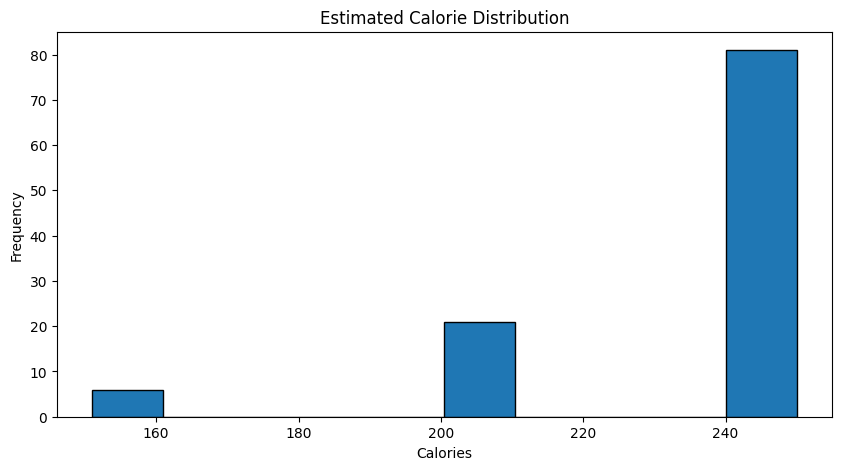

In [35]:
calories = predictions_df['Estimated Calories'].astype(float)
plt.figure(figsize=(10, 5))
plt.hist(calories, bins=10, edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Estimated Calorie Distribution')
plt.show()


**Track and Save User Intake**

In [42]:
intake_data = []

def track_intake(food_item, calories, portions=1):
    total_calories = calories * portions
    intake_data.append({"Food": food_item, "Calories": calories, "Portions Consumed": portions, "Total Calories": total_calories})
    intake_df = pd.DataFrame(intake_data)
    intake_df.to_csv('user_intake.csv', index=False)
    print(f"Tracked: {food_item}, Calories: {total_calories}")
    print(intake_df)

In [43]:
for img_path, food_item, calories in predictions:
    track_intake(food_item, calories, portions=1)

Tracked: chicken_curry, Calories: 250
            Food  Calories  Portions Consumed  Total Calories
0  chicken_curry       250                  1             250
Tracked: chicken_curry, Calories: 250
            Food  Calories  Portions Consumed  Total Calories
0  chicken_curry       250                  1             250
1  chicken_curry       250                  1             250
Tracked: chicken_curry, Calories: 250
            Food  Calories  Portions Consumed  Total Calories
0  chicken_curry       250                  1             250
1  chicken_curry       250                  1             250
2  chicken_curry       250                  1             250
Tracked: chicken_curry, Calories: 250
            Food  Calories  Portions Consumed  Total Calories
0  chicken_curry       250                  1             250
1  chicken_curry       250                  1             250
2  chicken_curry       250                  1             250
3  chicken_curry       250                